In [2]:
# Импортируем все необходиме модули
# pandas -- для создания датафреймов, как в r, в питоне
# os -- для того, чтобы обращаться к папкам и вообще работать с файловой системой
# seaborn -- для того, чтобы делать красивые картинки
# matplotlib -- этот модуль нужен для seaborn

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 10)

In [3]:
# Напишем функцию, которая будет загружать наш датасет и добавлять необходимые
# колонки для построения графика

def make_proper_df(df_name):
    # Смотрим, где мы
    where_am_i = os.getcwd()
    
    # Грузим в df наш датасет
    df = pd.read_csv(os.path.join(where_am_i, 'tsv_files', df_name), sep='\t')
    
    # Добавляем в наш df четыре столбика
    # ase_normal -- процент АСЭ генов в норме
    # ase_tumor -- процент АСЭ генов в опухоли
    # total_percent -- по сути везде пишется 100 % (это нужно для построения графика, 
    # никакой смысловой нагрузки этот столик не несет)
    # total_count -- количество образцов (и нормы, и опухоли), которые тестировали
    df['ase_freq_normal'] = df.count_normal/df.total_normal * 100
    df['ase_freq_tumor'] = df.count_tumor/df.total_tumor * 100
    df['total_percent'] = df.total_normal/df.total_normal * 100
    df['total_count'] = df.total_normal + df.total_tumor
    
    df.rename(columns={'median_normal':'maf_median_normal'}, inplace=True)
    df.rename(columns={'median_tumor':'maf_median_tumor'}, inplace=True)
    df.rename(columns={'average_normal':'maf_average_normal'}, inplace=True)
    df.rename(columns={'average_tumor':'maf_average_tumor'}, inplace=True)
    df.rename(columns={'stdev_normal':'maf_stdev_normal'}, inplace=True)
    df.rename(columns={'stdev_tumor':'maf_stdev_tumor'}, inplace=True)
    
    return df

In [5]:
# Грузим список наших генов
df = make_proper_df('statistics_ext.tsv')
# df

In [6]:
# Грузим сегментрано дуплицированные гены
where_am_i = os.getcwd()
pic_path = os.path.abspath(os.path.join(where_am_i, '..', 'pics_for_publication'))

df_segm_dupl = pd.read_csv(os.path.join(where_am_i, 'tsv_files', 'segm_dupl.tsv'), sep='\t')

In [7]:
# Тут перечислены все гены, которые не являются супер дуплицированными
df_nsd = df.query("gene not in @df_segm_dupl.gene")
df_nsd = df_nsd.reset_index(drop=True)
# df_nsd

In [8]:
# Тут перечислены все гены, для которых показан геномный импринтинг
# взял с geneimprint.com
df_imprinted = pd.read_csv(os.path.join(where_am_i, 'tsv_files', 'imprinted_genes.tsv'))
# df_imprinted

In [16]:
# Потенциально импринтированные гены
df_nsd_imp = df_nsd.query("gene in @df_imprinted.Gene")
df_nsd_imp = df_nsd_imp.reset_index(drop=True)
# df_nsd_imp

In [59]:
df_trial = df_nsd.query('(total_normal > 7) & (total_tumor > 7) & \
    (ase_freq_normal < 100) & (ase_freq_tumor < 100) & (count_normal > 2) & (count_tumor > 2)')
df_trial = df_trial.reset_index(drop=True)
# df_trial

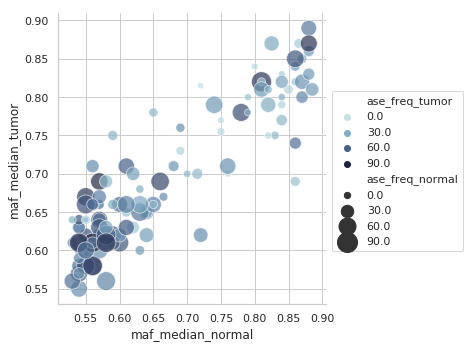

In [48]:
sns.set(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.relplot(x="maf_median_normal", y="maf_median_tumor", 
            size='ase_freq_normal', 
            hue='ase_freq_tumor',
            sizes=(40, 400), alpha=.7, palette=cmap,
            data=df_trial)._legend.remove()
plt.legend(bbox_to_anchor=(1,.75))
plt.savefig(os.path.join(pic_path, 'all_ase.png'), dpi=400, bbox_inches='tight')

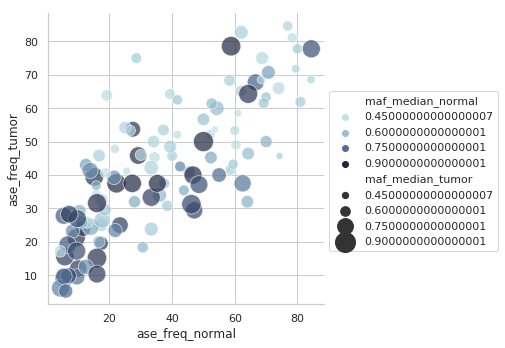

In [33]:
sns.set(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.relplot(x="ase_freq_normal", y="ase_freq_tumor", 
            size='maf_median_tumor', 
            hue='maf_median_normal',
            sizes=(40, 400), alpha=.7, palette=cmap,
            data=df_trial)._legend.remove()
plt.legend(bbox_to_anchor=(1,.75))
plt.savefig(os.path.join(pic_path, 'all_maf.png'), dpi=400, bbox_inches='tight')

# sns.relplot(x="ase_freq_normal", y="ase_freq_tumor", 
#             size='maf_median_normal', 
#             #hue='maf_median_normal',
#             sizes=(40, 400), alpha=.7, palette=cmap,
#             data=df_trial, facet_kws=dict(sharex=False, sharey=True))
# plt.savefig(os.path.join(pic_path, 'maf_normal.png'), dpi=400, bbox_inches='tight')

# f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
# hl_dict = {'maf_median_tumor': 'maf_tumor', 'maf_median_normal': 'maf_normal'}

# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
# for j in range(2):
#     sns.relplot(x="ase_freq_normal", y="ase_freq_tumor", 
# #             hue=list(hl_dict.keys())[j], 
#             size=list(hl_dict.keys())[j], 
#             sizes=(40, 400), alpha=.8, palette=cmap, 
#             data=df_trial,ax=ax[j])

# f.legend(loc="upper right", frameon=True)

### Сделаем картинку, где будут отображены гены, где частота АСЭ в опухоли выше, чем в норме

In [36]:
# Это то, что будет оставлено в датасете

# (total_normal > 7) & (total_tumor > 7) -- количество образцов в норме и опухоли,
# которые подавали mbased, больше 7 (число из головы)

# (ase_tumor/ase_normal <= 2) -- частота АСЭ в опухоли в 2 раза и больше выше,
# чем в норме (просто хотел показать, что таких вариантов очень много)

# (ase_normal < 100) & (ase_tumor < 100) -- это проверка на то, чтобы количество
# АСЭ образцов было НЕ больше, чем тестируемых образцов (такое действительно есть!)

df_htase = df_nsd.query('(total_normal > 7) & (total_tumor > 7) & \
    (ase_freq_tumor/ase_freq_normal > 2) & (ase_freq_normal < 100) & (ase_freq_tumor < 100)')
df_htase = df_htase.reset_index(drop=True)
# df_htase

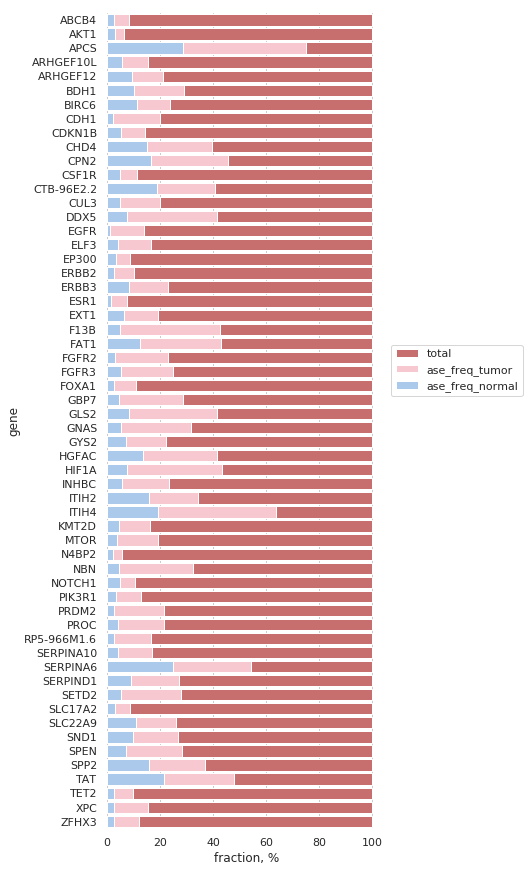

In [56]:
# Создаем картинку вида stacked barplot в seaborn

sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(5, 15))

sns.set_color_codes("muted")
sns.barplot(x='total_percent', y="gene", data=df_htase,
            label="total", color="r")

sns.set_color_codes("muted")
sns.barplot(x='ase_freq_tumor', y="gene", data=df_htase,
            label="ase_freq_tumor", color='pink')

sns.set_color_codes("pastel")
sns.barplot(x="ase_freq_normal", y="gene", data = df_htase,
            label="ase_freq_normal", color="b")

# ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(ylabel="gene",
       xlabel="fraction, %")
sns.despine(left=True, bottom=True)

plt.legend(bbox_to_anchor=(1, .6))
plt.savefig(os.path.join(pic_path, 'high_tumor_ase_frequency.png'), dpi=400, bbox_inches='tight')

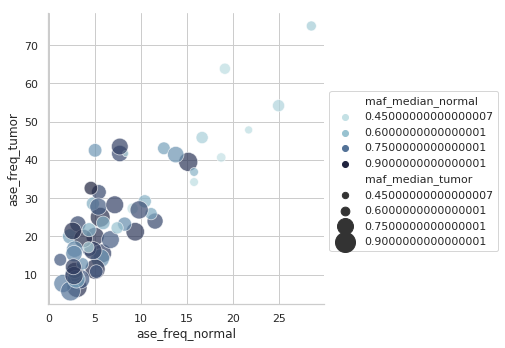

In [38]:
sns.set(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.relplot(x="ase_freq_normal", y="ase_freq_tumor", 
            size='maf_median_tumor', 
            hue='maf_median_normal',
            sizes=(40, 400), alpha=.7, palette=cmap,
            data=df_htase)._legend.remove()
plt.legend(bbox_to_anchor=(1,.75))
plt.savefig(os.path.join(pic_path, 'maf_htase.png'), dpi=400, bbox_inches='tight')

### Гены, где частота АСЭ в норме выше, чем в опухоли

In [39]:
# Все гены, у которых (ase_normal/ase_tumor > 2)
df_hnase = df_nsd.query('(total_normal > 7) & (total_tumor > 7) & \
    (ase_freq_normal/ase_freq_tumor > 2) & (ase_freq_normal < 100) & (ase_freq_tumor < 100)')
df_hnase = df_hnase.reset_index(drop=True)
# df_hnase

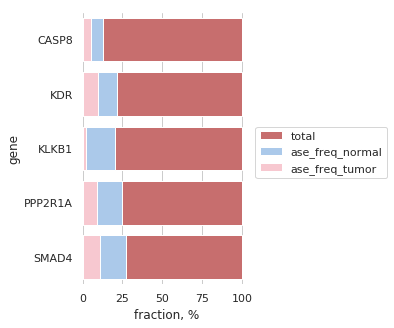

In [54]:
# Создаем картинку вида stacked barplot в seaborn

sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(3, 5))

sns.set_color_codes("muted")
sns.barplot(x='total_percent', y="gene", data=df_hnase,
            label="total", color="r")

sns.set_color_codes("pastel")
sns.barplot(x="ase_freq_normal", y="gene", data = df_hnase,
            label="ase_freq_normal", color="b")

sns.set_color_codes("muted")
sns.barplot(x='ase_freq_tumor', y="gene", data=df_hnase,
            label="ase_freq_tumor", color='pink')

# ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(ylabel="gene",
       xlabel="fraction, %")
sns.despine(left=True, bottom=True)

plt.legend(bbox_to_anchor=(1, .6))
plt.savefig(os.path.join(pic_path, 'high_normal_ase_frequency.png'), dpi=400, bbox_inches='tight')

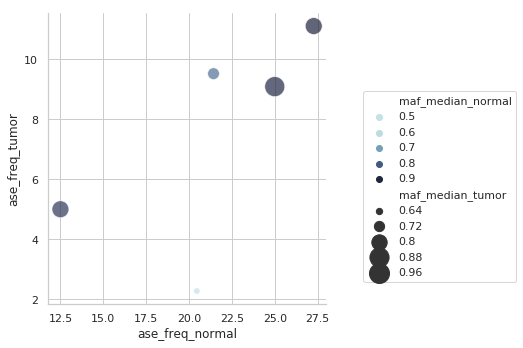

In [43]:
sns.set(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.relplot(x="ase_freq_normal", y="ase_freq_tumor", 
            size='maf_median_tumor', 
            hue='maf_median_normal',
            sizes=(40, 400), alpha=.7, palette=cmap,
            data=df_hnase)._legend.remove()
plt.legend(bbox_to_anchor=(1.7,.75))
# plt.savefig(os.path.join(pic_path, 'maf_hnase.png'), dpi=400, bbox_inches='tight')

### Теперь сделаем картинку, где отобразим все гены, у которых хотя бы в половине образцов наблюдается АСЭ (и в норме, и в опухоли) + частота АСЭ в опухоли выше, чем в норме

In [44]:
# Это то, что будет оставлено в датасете

# Большинство условий такие же, как в предыдущем условии
# (ase_tumor/ase_normal > 1.0) -- частота АСЭ в опухоли выше, чем в норме

# (count_normal/total_normal > 0.5) & (count_tumor/total_tumor > 0.5) -- 
# хотя бы в половине образцов наблюдается АСЭ (и в норме, и в опухоли)
 
df_hase = df_nsd.query('(total_normal > 7) & (total_tumor > 7) & (count_tumor/total_tumor > 0.5) & \
    (count_normal/total_normal > 0.5) & (ase_freq_normal < 100) & (ase_freq_tumor < 100) & \
    (ase_freq_tumor/ase_freq_normal > 1.0)')
df_hase = df_hase.reset_index(drop=True)
# df_hase

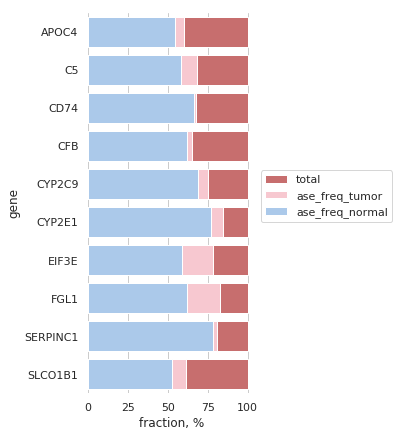

In [58]:
# Делаем картинку

sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(3, 7))

sns.set_color_codes("muted")
sns.barplot(x='total_percent', y="gene", data=df_hase,
            label="total", color="r")

sns.set_color_codes("muted")
sns.barplot(x='ase_freq_tumor', y="gene", data=df_hase,
            label="ase_freq_tumor", color='pink')

sns.set_color_codes("pastel")
sns.barplot(x="ase_freq_normal", y="gene", data = df_hase,
            label="ase_freq_normal", color="b")

# ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(ylabel="gene",
       xlabel="fraction, %")
sns.despine(left=True, bottom=True)

plt.legend(bbox_to_anchor=(1,.6))
plt.savefig(os.path.join(pic_path, 'high_ase_frequency.png'), dpi=400, bbox_inches='tight')

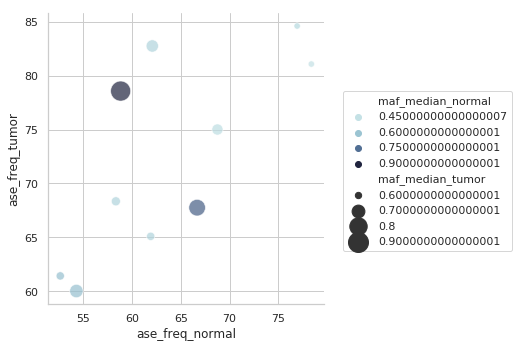

In [61]:
sns.set(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.relplot(x="ase_freq_normal", y="ase_freq_tumor", 
            size='maf_median_tumor', 
            hue='maf_median_normal',
            sizes=(40, 400), alpha=.7, palette=cmap,
            data=df_hase)._legend.remove()
plt.legend(bbox_to_anchor=(1.7,.75))
# plt.savefig(os.path.join(pic_path, 'maf_hase.png'), dpi=400, bbox_inches='tight')